# Acrobot : Reinforcement Learning

![image](images/acrobot.gif)

## Description
The system consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

### Action Space
The action is discrete, deterministic, and represents the torque applied on the actuated joint between the two links.
- 0 : apply -1 torque to the actuated joint
- 1 : apply 0 torque to the actuated joint
- 2 : apply 1 torque to the actuated joint

### Observation Space
The observation is a ndarray with shape (6,) that provides information about the two rotational joint angles as well as their angular velocities.
- 0 : cosine of theta1 [-1, 1]
- 1 : sine of theta1 [-1, 1]
- 2 : cosine of theta2 [-1, 1]
- 3 : sine of theta2 [-1, 1]
- 4 : angular velocity of theta1 [-12.567 (-4 * pi), 12.567 (4 * pi)]
- 5 : angular velocity of theta2 [-28.274 (-9 * pi), 28.274 (9 * pi)]

### Starting State
Each parameter in the underlying state (theta1, theta2, and the two angular velocities) is initialized uniformly between -0.1 and 0.1. This means both links are pointing downwards with some initial stochasticity.

### Reward
The goal is to have the free end reach a designated target height in as few steps as possible, and as such all steps that do not reach the goal incur a reward of -1. Achieving the target height results in termination with a reward of 0. The reward threshold is -100.

### Episode End
The episode ends if one of the following occurs:
- Termination: The free end reaches the target height, which is constructed as: -cos(theta1) - cos(theta2 + theta1) > 1.0
- Truncation: Episode length is greater than 500 (200 for v0)

In [1]:
import numpy as np
import gymnasium as gym
from tqdm import *
import matplotlib.pyplot as plt

In [18]:
env = gym.make("Acrobot-v1", render_mode = None)
n_actions = env.action_space.n
shape_states = env.observation_space.shape
np.random.seed(42)

## 1. Reinforcement by parametrization

The code below is general and will therefore be used several times, and that's why we define it here.

In [19]:
def agent_play(env, max_n_episodes=1000, max_steps=10000):
    count = 0
    rewards = []
    num_steps = []
    for _ in trange(max_n_episodes):
        s=env.reset()[0][None,:]
        total_reward = 0
        for i in range(max_steps):
            proba = parametrization(s, params)
            action = np.random.choice([0, 1, 2], p = proba[0])
            s, r, done, tr,_ = env.step(action)
            s = s[None,:]
            total_reward+=r
            if done or tr: 
                rewards.append(total_reward)
                num_steps.append(i+1)
                count+=1
                break
    avg_num_steps = np.mean(num_steps)
    print(f'Average number of steps = {avg_num_steps}')
    return rewards, num_steps

### 1.1 Softmax

We will use the softmax function to parameterize the policy. The softmax function takes in input a parameter vector $\theta$ and returns a probability vector of the same size.

The log-softmax function is defined as follows:

$$\log\left(\frac{\exp(z_i)}{\sum_j \exp(z_j)}\right)$$

where $z_i$ is the $i$-th element of a vector of logits. The gradient of the log-softmax function with respect to the logits is:

$$\frac{\partial}{\partial z_i} \log\left(\frac{\exp(z_i)}{\sum_j \exp(z_j)}\right) = \frac{\partial}{\partial z_i} \left( z_i - \log\left(\sum_j \exp(z_j)\right) \right)$$

To compute this gradient, we can start by taking the derivative of the logarithm term:

$$\frac{\partial}{\partial z_i} \log\left(\sum_j \exp(z_j)\right) = \frac{1}{\sum_j \exp(z_j)} \cdot \frac{\partial}{\partial z_i} \sum_j \exp(z_j)$$

Note that the sum in the denominator is over all the logits $z_j$, and the sum in the numerator is only over the logits that correspond to the $i$-th action. Therefore, we can simplify the expression as follows:

$$\frac{\partial}{\partial z_i} \log\left(\sum_j \exp(z_j)\right) = \frac{\exp(z_i)}{\sum_j \exp(z_j)}$$

Next, we can use the chain rule to compute the derivative of the entire log-softmax function:

$$\frac{\partial}{\partial z_i} \log\left(\frac{\exp(z_i)}{\sum_j \exp(z_j)}\right) = \frac{\partial}{\partial z_i} \left( z_i - \log\left(\sum_j \exp(z_j)\right) \right) = 1 - \frac{\exp(z_i)}{\sum_j \exp(z_j)} = 1 - \mathrm{softmax}(z)_i$$

where $\mathrm{softmax}(z)_i$ is the $i$-th element of the softmax function applied to the logits $z$. Therefore, the gradient of the log-softmax function with respect to the logits is simply the difference between 1 and the probability of selecting the $i$-th action according to the softmax function

In [20]:
def softmax(alpha) :
    proba = np.exp(alpha)
    return proba/proba.sum()

def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

def parametrization(x,theta):
    z = x.dot(theta)
    return softmax(z)

In [21]:
def REINFORCE(env, learning_rate=0.000025, gamma=0.99, num_episodes=10000, max_steps=500):
    n_actions = env.action_space.n
    params = np.random.rand(6,n_actions)
    for _ in trange(num_episodes):
        state = env.reset()[0][None,:]
        grads = []
        rewards = []
        score = 0
        for _ in range(max_steps):
            probs = parametrization(state,params)
            action = np.random.choice(n_actions,p=probs[0])
            next_state,reward,done,truncated, _ = env.step(action)
            next_state = next_state[None,:] # For shape correctness
            dsoftmax = softmax_grad(probs)[action,:]
            dlog = dsoftmax / probs[0,action]
            grad = state.T.dot(dlog[None,:])
            grads.append(grad)
            rewards.append(reward)
            score += reward
            state = next_state
            if done or truncated:
                break
        for i in range(len(grads)):
            params += learning_rate * grads[i] * sum([ r * (gamma ** r) for t,r in enumerate(rewards[i:])])
    return params

In [5]:
params = REINFORCE(env)

Started REINFORCE Learning


100%|██████████| 10000/10000 [02:57<00:00, 56.34it/s]

Finished REINFORCE Learning


In [8]:
env = gym.make("Acrobot-v1", render_mode = None)
obs, info = env.reset()

rewards, num_steps = agent_play(env)

100%|██████████| 1000/1000 [00:14<00:00, 71.36it/s]

Average number of steps = 86.659


C:\Users\leche\AppData\Local\Temp\ipykernel_74044\3679638419.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(np.arange(len(rewards)), np.cumsum(rewards)/np.arange(len(rewards)), label="Cumulative Average Reward for Reinforce algorithms")


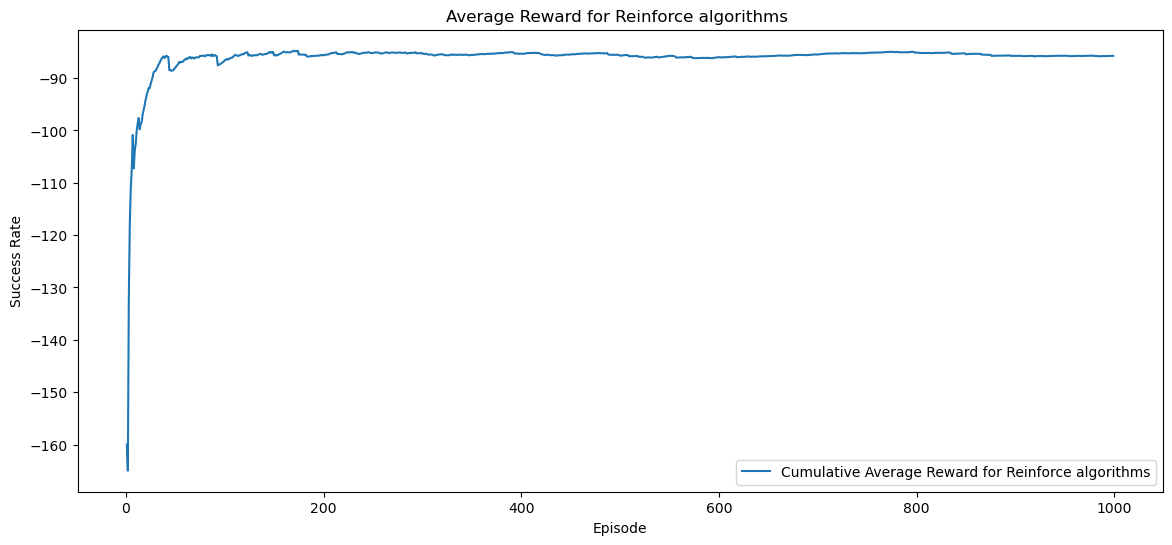

In [9]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards)), np.cumsum(rewards)/np.arange(len(rewards)), label="Cumulative Average Reward for Reinforce algorithms")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Reward for Reinforce algorithms ')
plt.legend()
plt.show()

### 1.2 Corrected Arc-tangent

In order to improve the performances, we are going to test another function than the softmax one, which is a corrected version of the arc-tangent function, defined as follow for a vector x of size n :

$$ f((x_i)_{1 \leq i \leq n}) = \left(\frac{Arctan(x_i) + \frac{\pi}{2}}{\sum_{j=1}^{n} Arctan(x_j) + \frac{\pi}{2}} \right)_{1 \leq i \leq n} $$

It is necessary to add $\frac{\pi}{2}$ to each terme in order not to have negative values as we will use this function later to define probabilities.

We are now going to calculates the gradient of $f((x_i)_{1 \leq i \leq n})$ as defined above.

First we begin with the case where $i = j$ :

$$ \frac{\delta}{\delta \alpha_i} \left(
\frac{\frac{\pi}{2} + Arctan(\alpha_i)}{\sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2}} \right) =
\frac{\frac{1}{1+\alpha_i} \left(\sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2}\right) - \left(\frac{\pi}{2} + Arctan(\alpha_i) \right) \frac{\delta}{\delta \alpha_i} \left(\sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2}\right)}  {\left(\sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2}\right)²} $$

$$ \frac{\delta}{\delta \alpha_i} \left(
\frac{\frac{\pi}{2} + Arctan(\alpha_i)}{\sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2}} \right) =
\frac{\left(\sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2}\right) - \left(\frac{\pi}{2} + Arctan(\alpha_i) \right)}  {\left(1+\alpha_i^{2}\right) \left(\sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2}\right)²} $$

And we continue with the case where $i \neq j$ :

$$ \frac{\delta}{\delta \alpha_j} \left(
\frac{\frac{\pi}{2} + Arctan(\alpha_i)}{\sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2}} \right) = \left( \frac{\pi}{2} + Arctan(\alpha_i) \right) \left( \frac{-\frac{\delta}{\delta \alpha_j} \left( \sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2} \right) } {\left( \sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2} \right)²} \right) $$

$$ \frac{\delta}{\delta \alpha_j} \left(
\frac{\frac{\pi}{2} + Arctan(\alpha_i)}{\sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2}} \right) =
- \frac{ \left( \frac{\pi}{2} + Arctan(\alpha_i) \right) } {\left(1+\alpha_i^{2}\right) \left( \sum_{k=1}^{n} Arctan(x_k) + \frac{\pi}{2} \right)²} $$

In [169]:
def corr_arctan(alpha):
    proba = np.arctan(alpha)+np.array([np.pi/2 for a in alpha]) # pour avoir des proba non négatives
    return proba/proba.sum()

def corr_arctan_grad(alpha):
    s = np.arctan(alpha)+np.array([np.pi/2 for a in alpha])
    size = len(alpha)
    grad = [[0 for a in range(size)] for b in range(size)]
    for i in range(size):
        for j in range(size):
            if j!=i:
                grad[j][i] = -s[i]/((1+alpha[j]**2)*(sum(s)**2))
            else:
                grad[j][i] = float((sum(s)-s[i])/((1+alpha[j]**2)*(sum(s)**2)))
    return np.array(grad)

def parametrization(x,theta):
    z = x.dot(theta)
    return corr_arctan(z)

In [170]:
def REINFORCE(env, learning_rate =0.000025,gamma = 0.99, num_episodes = 10000, max_steps=500):
    n_actions = env.action_space.n
    params = np.random.rand(6,n_actions)
    for _ in trange(num_episodes):
        state = env.reset()[0][None,:]
        grads = []
        rewards = []
        score = 0
        for _ in range(max_steps):
            probs = parametrization(state,params)
            action = np.random.choice(n_actions,p=probs[0])
            next_state,reward,done,truncated, _ = env.step(action)
            next_state = next_state[None,:] # For shape correctness
            dcorr_arctan = corr_arctan_grad(probs[0])[action,:] # probs[0] au lieu de probs
            dlog = dcorr_arctan / probs[0,action]
            grad = state.T.dot(dlog[None,:])
            grads.append(grad)
            rewards.append(reward)
            score += reward
            state = next_state
            if done or truncated:
                break
        for i in range(len(grads)):
            params += learning_rate * grads[i] * sum([ r * (gamma ** r) for t,r in enumerate(rewards[i:])])
    return params

In [171]:
params = REINFORCE(env)

Started REINFORCE Learning


100%|██████████| 10000/10000 [04:44<00:00, 35.10it/s]

Finished REINFORCE Learning


In [172]:
env = gym.make("Acrobot-v1", render_mode = None)
obs, info = env.reset()

rewards, num_steps = agent_play(env)

100%|██████████| 1000/1000 [00:20<00:00, 48.64it/s]

Average number of steps = 118.891


C:\Users\leche\AppData\Local\Temp\ipykernel_74044\3471814334.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(np.arange(len(rewards)), np.cumsum(rewards)/np.arange(len(rewards)), label="Cumulative Average Reward for Reinforce algorithms")


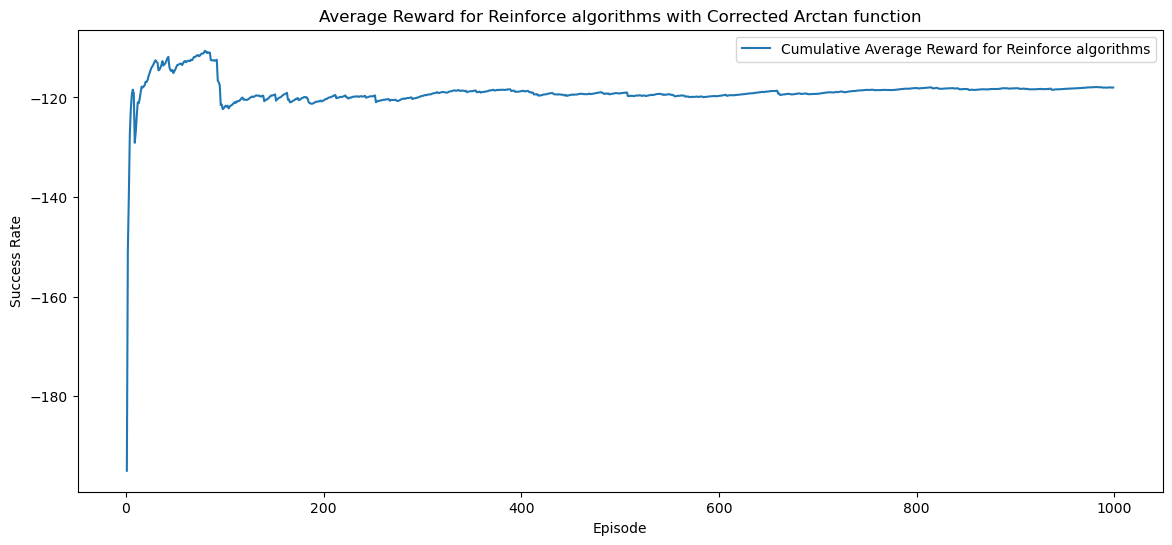

In [173]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards)), np.cumsum(rewards)/np.arange(len(rewards)), label="Cumulative Average Reward for Reinforce algorithms")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Reward for Reinforce algorithms with Corrected Arctan function')
plt.legend()
plt.show()

## 2. Tuning Learning Rate and Gamma

Having obtained that the performances were better by using the softmax function rather than the corrected arc-tangent one, we will now look for values of learning rate and gamma which allow an improvement of the performances.

We start by testing the performance for a few values of learning rates and gammas.

In [ ]:
learning_rates = [0.00001,0.00002,0.00005,0.0001]
gammas = [0.8,0.9,0.95,0.99]

for lr in learning_rates:
    for gam in gammas:
        params = REINFORCE(env, learning_rate=lr, gamma=gam)
        env = gym.make("Acrobot-v1", render_mode = None)
        obs, info = env.reset()
        legend = "lr : "+str(lr)+" et gamma : "+str(gam)
        print(legend)
        rewards, num_steps = agent_play(env)
        print("")

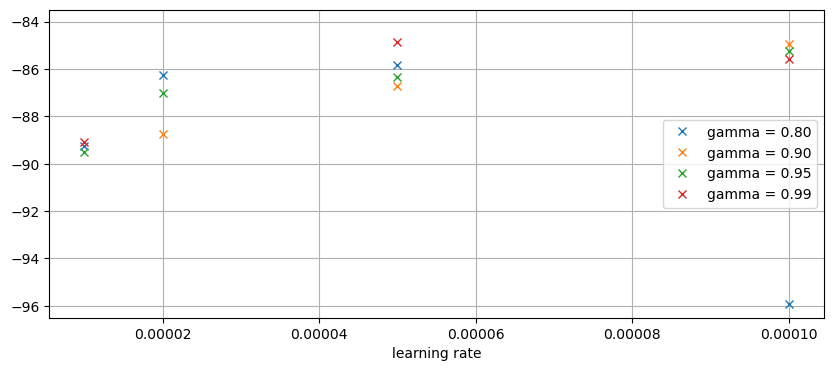

In [3]:
plt.figure(figsize=(10,4))

plt.plot([1*10**(-5),2*10**(-5),5*10**(-5),10*10**(-5)], [-89.261,-86.258,-85.813,-95.939],'x', label='gamma = 0.80')
plt.plot([1*10**(-5),2*10**(-5),5*10**(-5),10*10**(-5)], [-500,-88.732,-86.711,-84.947],'x', label='gamma = 0.90')
plt.plot([1*10**(-5),2*10**(-5),5*10**(-5),10*10**(-5)], [-89.503,-87.017,-86.354,-85.237],'x', label='gamma = 0.95')
plt.plot([1*10**(-5),2*10**(-5),5*10**(-5),10*10**(-5)], [-89.093,-500,-84.852,-85.586],'x', label='gamma = 0.99')

plt.ylim(-96.5,-83.5)
plt.xlabel("learning rate")
plt.legend()
plt.grid()
plt.show()

One can notice that sometimes we obtained a reward of -500 because of the beginning position of theta.

As the performances for the learning rate of 0.0001 were ones of the betters, for future hyperparameters tuning, we will choose to explore values of learning rate around 0.0001 and values of gammas between 0.90 and 0.95.

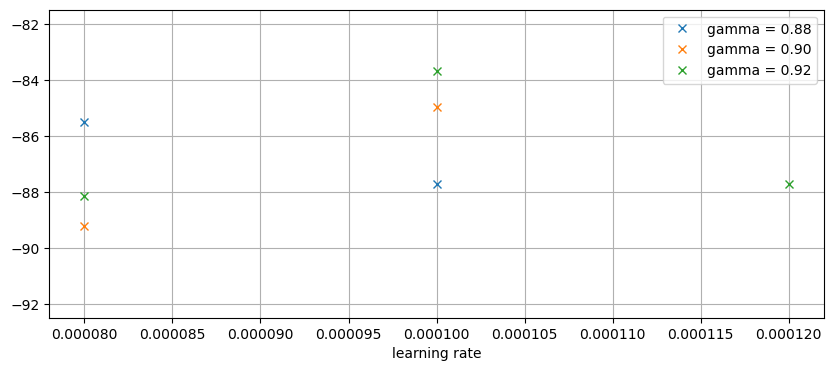

In [46]:
plt.figure(figsize=(10,4))

plt.plot([8*10**(-5),10**(-4),1.2*10**(-4)], [-85.511,-87.721,-500],'x', label='gamma = 0.88')
plt.plot([8*10**(-5),10**(-4),1.2*10**(-4)], [-89.227,-84.984,-500],'x', label='gamma = 0.90')
plt.plot([8*10**(-5),10**(-4),1.2*10**(-4)], [-88.17,-83.677,-87.728],'x', label='gamma = 0.92')

plt.ylim(-92.5,-81.5)
plt.xlabel("learning rate")
plt.legend(bbox_to_anchor=(1.,1))
plt.grid()
plt.show()

With these new calculus, it seems that the best hyperparameters are 0.0001 for the learning rate, and 0.92 for gamma.

We are now going to double the number of episodes in order to see whether or not in enables to improve performances.

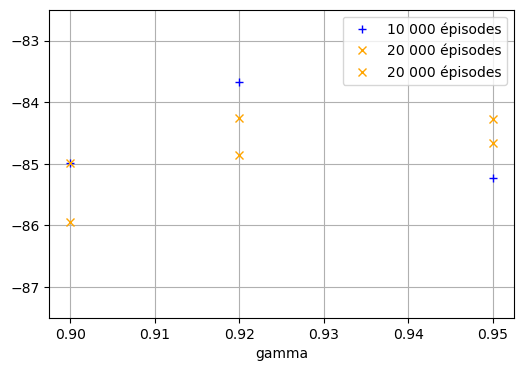

In [2]:
plt.figure(figsize=(6,4))

plt.plot([0.90,0.92,0.95], [-84.984,-83.677,-85.237],'+', color='blue', label='10 000 épisodes')
plt.plot([0.90,0.92,0.95], [-84.981,-84.865,-84.668],'x', color='orange', label='20 000 épisodes')
plt.plot([0.90,0.92,0.95], [-85.948,-84.257,-84.276],'x', color='orange', label='20 000 épisodes')

plt.ylim(-87.5,-82.5)
plt.xlabel("gamma")
plt.legend(bbox_to_anchor=(1,1))
plt.grid()
plt.show()

From this graphic we can only say than doubling the number of episodes did not improve the performances we already have.

Therefore we will keep these values of hyperparameters (0.0001 for the learning rate and 0.92 for gamma), but now we are going to implement a method in which the learning rate gradually decreases, to finally be worth ten times less than its initial value.

In [6]:
def REINFORCE_DECR(env, learning_rate=0.000025, gamma=0.99, num_episodes=10000, max_steps=500):
    n_actions = env.action_space.n
    params = np.random.rand(6,n_actions)
    lr = learning_rate
    for _ in trange(num_episodes):
        state = env.reset()[0][None,:]
        grads = []
        rewards = []
        score = 0
        lr = lr - 0.9/num_episodes*learning_rate
        for _ in range(max_steps):
            probs = parametrization(state,params)
            action = np.random.choice(n_actions,p=probs[0])
            next_state,reward,done,truncated, _ = env.step(action)
            next_state = next_state[None,:] # For shape correctness
            dsoftmax = softmax_grad(probs)[action,:]
            dlog = dsoftmax / probs[0,action]
            grad = state.T.dot(dlog[None,:])
            grads.append(grad)
            rewards.append(reward)
            score += reward
            state = next_state
            if done or truncated:
                break
        for i in range(len(grads)):
            params += lr * grads[i] * sum([ r * (gamma ** r) for t,r in enumerate(rewards[i:])])
    return params

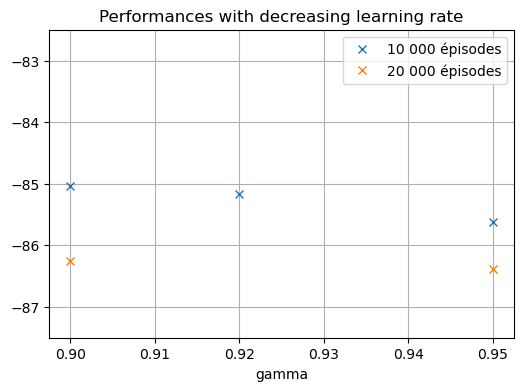

In [4]:
plt.figure(figsize=(6,4))

plt.plot([0.90,0.92,0.95], [-85.033,-85.164,-85.623],'x', label='10 000 épisodes')
plt.plot([0.90,0.92,0.95], [-86.254,-153.993,-86.386],'x', label='20 000 épisodes')

plt.ylim(-87.5,-82.5)
plt.title("Performances with decreasing learning rate")
plt.xlabel("gamma")
plt.legend(bbox_to_anchor=(1,1))
plt.grid()
plt.show()

This method did not improve our previous performances.

Finally, the best performance we obtained is a reward between -83.5 and -84 with 0.0001 for the learning rate and 0.92 for gamma.